## Config

In [202]:
import matplotlib.pyplot as plt

In [203]:
%matplotlib inline

In [755]:
from numpy import outer, eye, ones, zeros, diag, log, sqrt, exp, pi
from numpy.linalg import inv, solve
from numpy.random import multivariate_normal as mvnormal, normal, gamma, beta, binomial
from scipy.special import gammaln
from scipy.stats import norm, multivariate_normal

from numpy import zeros
from numpy.random import randn

import numpy as np

import matplotlib.pyplot as plt
from numpy import arange, min, max, sqrt, mean, std
from scipy.spatial.distance import cosine

import copy

In [205]:
np.seterr(all='raise') # TODO REMOVE

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## EM-algorithm

In [973]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

mm_cumulative_error = 0.0 # TODO REMOVE
mm_max_diff = 0.0 # TODO REMOVE

class EM_algo():
    """
        A superclass for different EM-fitted models.
    """

    def __init__(self, hyperparams, X=None, Y=None, ndata=0, pdata=0):
        """
            Initialize model based either on given data (X, Y) or
            on given data dimensionality (ndata, pdata).
        """
        if not X is None and not Y is None:
            self.X = X
            self.Y = Y
            self.ndata = len(self.X)
            self.pdata = len(self.X[0])
        if ndata and pdata:
            self.X = None
            self.Y = None
            self.ndata = ndata
            self.pdata = pdata
        self.h = hyperparams
        self.p = dict() # model parameters
        self.reset()
        if not X is None and not Y is None:
            self.current_logl, self.cll = self.logl()


    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        raise NotImplementedError("Subclass implements")


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the drawn y and z-values.
        """
        raise NotImplementedError("Subclass implements")


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        raise NotImplementedError("Subclass implements")


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.
        """
        raise NotImplementedError("Subclass implements")


    def EM_fit(self, alim=1e-10, maxit=1e4):
        """
            Calls the EM_iter repeatedly until the log likelihood
            of the model increases less than 'alim' in absolute
            value or after 'maxit' iterations have been done.

            Returns the number of EM-iterations, final log likelihood
            value and a string that explains the end condition.
        """
        logl, ll = self.logl()
        for i in range(int(maxit)):
            self.EM_iter()
            logl2, ll2 = self.logl()
            adiff = abs(logl2 - logl)
            if adiff < alim:
                return i+1, logl2, "alim"
            logl = logl2
        return maxit, logl2, "maxit"


    def assert_logl_increased(self, event):
        """
            Checks that the log likelihood increased since model
            initialization or the time this function was last called.
        """
        newlogl, ll = self.logl()
        global mm_cumulative_error # TODO REMOVE
        global mm_max_diff # TODO REMOVE
        if self.current_logl > newlogl:
            if mm_max_diff < self.current_logl - newlogl:
                mm_max_diff = self.current_logl - newlogl
            mm_cumulative_error = mm_cumulative_error + (self.current_logl - newlogl)
#         if self.current_logl - newlogl > 10.0:
        if self.current_logl - newlogl > 0.1:
#         if self.current_logl - newlogl > 1e-3:
#             if not self.icll is None:
#             inewlogl, ill = self.incompletelogl()
# #             self.debug_logl(self.icll, ill)
#             self.debug_logl(self.cll, ll)
# #             print("logl decreased after %s" % (event))
#             if self.current_ilogl - inewlogl > 1e-3:
#                 raise ValueError("%s" % (event))
            raise RuntimeError("%s" % (event))
#             raise ValueError("%s" % (event))
#             raise ValueError("logl decreased after %s" % (event))
        self.current_logl, self.cll = newlogl, ll
#         if not self.icll is None:
#         self.current_ilogl, self.icll = self.incompletelogl()


    def get_p(self):
        """
            Returns a copy of the model parameters.
        """
        return copy.deepcopy(self.p)


    def set_p(self, p):
        """
            Sets the model parameters.
        """
        self.p = p.copy()


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        for k, v in self.p.items():
            print("%s = %s" % (k, v))


    def pretty_vector(self, x):
        """
            Returns a formatted version of a vector.
        """
        s = ["("]
        s.extend(["%.2f, " % (xi) for xi in x[:-1]])
        s.append("%.2f)" % (x[-1]))
        return "".join(s)


    def debug_logl(self, ll1, ll2):
        """
            Prints an analysis of the per-term change in
            log likelihood from ll1 to ll2.
        """
        print("Logl      before     after")
        for v1, v2, i in zip(ll1, ll2, range(len(ll1))):
            if v1 > v2:
                d = ">"
            elif v2 > v1:
                d = "<"
            else:
                d = "="
            print("Term %02d: %7.3f %s %7.3f" % (i, v1, d, v2))
        v1 = sum(ll1)
        v2 = sum(ll2)
        if v1 > v2:
            d = ">"
        elif v2 > v1:
            d = "<"
        else:
            d = "="
        diff = v2-v1
        print("Total    %7.3f %s %7.3f   diff: %7.3f" % (v1, d, v2, diff))



## Linear model

In [974]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

class EM_algo_LM_ML(EM_algo):
    """
        A linear gaussian model. MAXLIKELIHOOD INSTEAD OF MAP
    """

    def reset(self, responsibilities=None):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]

        # initial parameter estimates drawn from prior
        self.p           = dict()
        self.p["sigma2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi"]    = mvnormal(self.mu_phi0, self.p["sigma2"] * self.sigma_phi0)
        
        if not responsibilities is None:
            if not self.X is None and not self.Y is None:
                self.current_logl, self.cll = self.logl()
            


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value (and a constant z-value for compatibility)
        """
        mean = float(item.dot(self.p["phi"]))
        std  = sqrt(self.p["sigma2"])
        return normal(mean, std), 1


    def logl(self, responsibilities=None):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll    = zeros(8)
#         phie  = self.p["phi"] - self.mu_phi0
        err   = (self.X.dot(self.p["phi"]) - self.Y) ** 2
        
        if responsibilities is None:
            # p(y)
            ll[0] = - 0.5 * log(2 * pi * self.p["sigma2"]) * self.ndata
            ll[1] = sum(- 0.5 * err / self.p["sigma2"])
    #         # p(phi)
    #         ll[2] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2"]) * self.pdata
    #         ll[3] = - 0.5 * phie.T.dot(phie) / (self.lbd_phi0 * self.p["sigma2"])
    #         # p(sigma2)
    #         ll[4] = self.alpha_s20 * log(self.beta_s20)
    #         ll[5] = - gammaln(self.alpha_s20)
    #         ll[6] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2"])
    #         ll[7] = - self.beta_s20 / self.p["sigma2"]
        else:
            for t in range(self.ndata):
                tmp123 = 0.0
                for p in range(self.pdata):
                    tmp123 += self.p["phi"][p] * self.X[t,p]
                ll[0] += responsibilities[t] * norm.logpdf(self.Y[t], tmp123, sqrt(self.p["sigma2"]))
            # p(y)
#             ll[0] = responsibilities.dot( norm.logpdf(self.Y, self.X.dot(self.p["phi"]), sqrt(self.p["sigma2"])) )
#             ll[0] = - 0.5 * log(2 * pi * self.p["sigma2"]) * sum(responsibilities) # TODO HOX: or np.sum
#             ll[1] = responsibilities.dot(- 0.5 * err / self.p["sigma2"])
        return sum(ll), ll


    def EM_iter(self, responsibilities=None):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        if responsibilities is None:
            # phi
            sumxx         = self.X.T.dot(self.X)
            sumxy         = self.X.T.dot(self.Y)
            self.p["phi"] = solve(sumxx, sumxy)
            self.assert_logl_increased("phi update")

            # sigma2
            err  = (self.X.dot(self.p["phi"]) - self.Y) ** 2
            num  = sum(err)
            den  = self.ndata
            self.p["sigma2"] = num / den
            if self.p["sigma2"] < 0.0:
                raise ValueError("sigma2 < 0.0")
            self.assert_logl_increased("sigma2 update")
        else:
            # phi
            resp_matrix = eye(self.ndata) * responsibilities
            sumxx = self.X.T.dot(resp_matrix.dot(self.X))
            sumxy = responsibilities.T.dot( (self.Y * self.X.T).T )
            self.p["phi"] = solve(sumxx, sumxy)
#             self.assert_logl_increased("phi update")

            # sigma2
            phiX = self.p["phi"].dot(self.X.T)
            err = responsibilities.dot((self.Y - phiX)**2)
            num = err
            den = np.sum(responsibilities)
            self.p["sigma2"] = num / den
            if self.p["sigma2"] < 0.0:
                print(phiX, err, den)
                raise ValueError("sigma2 < 0.0")
#             self.assert_logl_increased("sigma2 update")


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        print("phi    : %s" % (self.pretty_vector(self.p["phi"])))
        print("sigma2 : %.3f" % (self.p["sigma2"]))



In [975]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

class EM_algo_LM(EM_algo):
    """
        A linear gaussian model.
    """

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]

        # initial parameter estimates drawn from prior
        self.p           = dict()
        self.p["sigma2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi"]    = mvnormal(self.mu_phi0, self.p["sigma2"] * self.sigma_phi0)


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value (and a constant z-value for compatibility)
        """
        mean = float(item.dot(self.p["phi"]))
        std  = sqrt(self.p["sigma2"])
        return normal(mean, std), 1


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll    = zeros(8)
        phie  = self.p["phi"] - self.mu_phi0
#         print("phie", phie.shape)
        err   = (self.X.dot(self.p["phi"]) - self.Y) ** 2
#         print("err", err.shape)
        # p(y)
        ll[0] = - 0.5 * log(2 * pi * self.p["sigma2"]) * self.ndata
        ll[1] = sum(- 0.5 * err / self.p["sigma2"])
        # p(phi)
        ll[2] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2"]) * self.pdata
        ll[3] = - 0.5 * phie.T.dot(phie) / (self.lbd_phi0 * self.p["sigma2"])
        # p(sigma2)
        ll[4] = self.alpha_s20 * log(self.beta_s20)
        ll[5] = - gammaln(self.alpha_s20)
        ll[6] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2"])
        ll[7] = - self.beta_s20 / self.p["sigma2"]
        return sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        # phi
        sumxx         = self.X.T.dot(self.X)
        sumxy         = self.X.T.dot(self.Y)
        sigma_mu      = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv = self.sigma_phi0_inv + sumxx
#         print("sigma_phi_inv.shape", sigma_phi_inv.shape)
        self.p["phi"] = solve(sigma_phi_inv, sigma_mu + sumxy)
#         print("sumxx", type(sumxx), "sumxy", type(sumxy), "sigma_mu", type(sigma_mu), "sigma_phi_inv", type(sigma_phi_inv))
#         print("sumxx", sumxx.shape, "sumxy", sumxy.shape, "sigma_mu", sigma_mu.shape, "sigma_phi_inv", sigma_phi_inv.shape)
        self.assert_logl_increased("phi update")

        # sigma2
        phie = (self.p["phi"] - self.mu_phi0) ** 2
        err  = (self.X.dot(self.p["phi"]) - self.Y) ** 2
        num  = self.beta_s20 + 0.5 * sum(err) + 0.5 * sum(phie) / self.lbd_phi0
        den  = self.alpha_s20 + 1.0 + 0.5 * (self.ndata + self.pdata)
        self.p["sigma2"] = num / den
#         print("phie", type(phie), "err", type(err), "num", type(num), "den", type(den))
#         print("phie", phie.shape, "err", err.shape, "num", num.shape, "den", "is a float")
        if self.p["sigma2"] < 0.0:
            raise ValueError("sigma2 < 0.0")
        self.assert_logl_increased("sigma2 update")


    def print_p(self):
        """
            Prints the model parameters, one at each line.
        """
        print("phi    : %s" % (self.pretty_vector(self.p["phi"])))
        print("sigma2 : %.3f" % (self.p["sigma2"]))



## Generator

In [976]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

def generate_X(ndata, pdata):
    """
        Return a matrix of normally distributed random values.
    """
    X = randn(ndata, pdata)
    return X


def generate_YZ(X, distribution):
    """
        Draw observations Y and latent variable values Z from a distribution.
    """
    ndata = len(X)
    Y = zeros(ndata)
    Z = zeros(ndata)
    for i in range(ndata):
        Y[i], Z[i] = distribution.draw(X[i])
    return Y, Z


def get_hyperp():
    """
        Return model hyperparameters.
    """
    return {
            "alpha_s20": 5.0,
            "beta_s20" : 1.0,
            "lbd_phi0" : 1.0,
            "mu_phi0"  : 0.0,
            "alpha_w0" : 3.0,
            "beta_w0"  : 3.0,
            }


## Mixture model

In [977]:
class EM_algo_MM_ML666(EM_algo):
    """
        A mixture of two linear models, ML instead of MAP.
    """
#     def __init__(self, hyperparams, X=None, Y=None, ndata=0, pdata=0):
#         super().__init__(hyperparams, X, Y, ndata, pdata)
# #         self.L1 = EM_algo_LM_ML(hyperparams, X, Y, ndata, pdata)
# #         self.L2 = EM_algo_LM_ML(hyperparams, X, Y, ndata, pdata)

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        
#         print("PARAMS", self.h, self.X, self.Y, self.ndata, self.pdata)
        
        self.L1 = EM_algo_LM_ML(self.h, X=self.X, Y=self.Y)
        self.L2 = EM_algo_LM_ML(self.h, X=self.X, Y=self.Y)
        
        # priors
        self.alpha_w0       = self.h["alpha_w0"]
        self.beta_w0        = self.h["beta_w0"]
        
        # initial parameter estimates drawn from prior
        self.p             = dict()
        # Weights
        self.p["w"]        = beta(self.alpha_w0, self.beta_w0)
        # Responsibilities (TODO: do we need this here?)
        self.gamma          = binomial(1, self.p["w"], self.ndata)
        
        self.L1.reset(self.gamma)
        self.L2.reset(1-self.gamma)
        
#         if not self.X is None and not self.Y is None:
#             self.current_ilogl, self.icll = self.incompletelogl()


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value and z-value
        """
        
        if np.random.rand() < self.p["w"]:
            y, z1 = self.L1.draw()
            return y, 1
        else:
            y, z1 = self.L2.draw()
            return y, 2


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
                
        ll         = zeros(20)
        
        L1_tot, L1_ll = self.L1.logl(self.gamma)
        L2_tot, L2_ll = self.L2.logl(1-self.gamma)
        ll[0] = L1_ll[0]
        ll[1] = L1_ll[1]
        ll[2] = L2_ll[0]
        ll[3] = L2_ll[1]
        
        ll[4] = 2*np.sum(self.gamma) * log(self.p["w"])
        ll[5] = 2*np.sum(1-self.gamma) * log(1-self.p["w"])
        
#         ll[4] = np.sum(L1_ll[2:])
#         ll[5] = np.sum(L2_ll[2:])
        
        ### p(w)
#         ll[6] = log(gamma(self.alpha_w0 + self.beta_w0)) - log(gammaln(self.alpha_w0)) - log(gammaln(self.beta_w0))
#         ll[7] = (self.alpha_w0 - 1) * self.p["w"]
#         ll[8] = (self.beta_w0  - 1) * (1 - self.p["w"])
        
        return np.sum(ll), ll
    
    
    def incompletelogl(self):
        """
            Calculates the incomplete data log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll    = zeros(2)

        ll[0] = self.p["w"] * norm.pdf(self.Y, self.X.dot(self.L1.p["phi"]), sqrt(self.L1.p["sigma2"]))
        ll[1] = (1-self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.L2.p["phi"]), sqrt(self.L2.p["sigma2"]))
        
        return np.sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        
        self.current_logl, self.cll = self.logl()
        
        # ==================== E-STEP ====================
        propto_gamma1 =      self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.L1.p["phi"]), sqrt(self.L1.p["sigma2"]))
        propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.L2.p["phi"]), sqrt(self.L2.p["sigma2"]))
#         propto_gamma1x =    log(self.p["w"])  * norm.logpdf(self.Y, self.X.dot(self.L1.p["phi"]), sqrt(self.L1.p["sigma2"]))
#         propto_gamma2x = log(1 - self.p["w"]) * norm.logpdf(self.Y, self.X.dot(self.L2.p["phi"]), sqrt(self.L2.p["sigma2"]))
        self.gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
#         print("GAMMADIFF", np.sum((propto_gamma1 / (propto_gamma1 + propto_gamma2) - (propto_gamma1x / (propto_gamma1x + propto_gamma2x)))))
        
        # ==================== M-STEP ====================
        
        self.L1.EM_iter(self.gamma)
        self.L2.EM_iter(1-self.gamma)
        
#         self.assert_logl_increased("L1,L2")
        
        self.p["w"] = sum(self.gamma) / self.ndata
        self.assert_logl_increased("w")

In [978]:
# generate a model for estimating the parameters of the
# true model based on the observations (X, Y) we just made
# model = EM_algo_MM(hyperp, X, Y)
model = EM_algo_MM_ML666(hyperp, X, Y)
i, logl, r = model.EM_fit()
print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
        (logl, i, r))
print("")
print("MAP estimate of true model parameters:")
model.print_p()
print("")

RuntimeError: w

In [979]:
model.p["w"]

0.60224419737558221

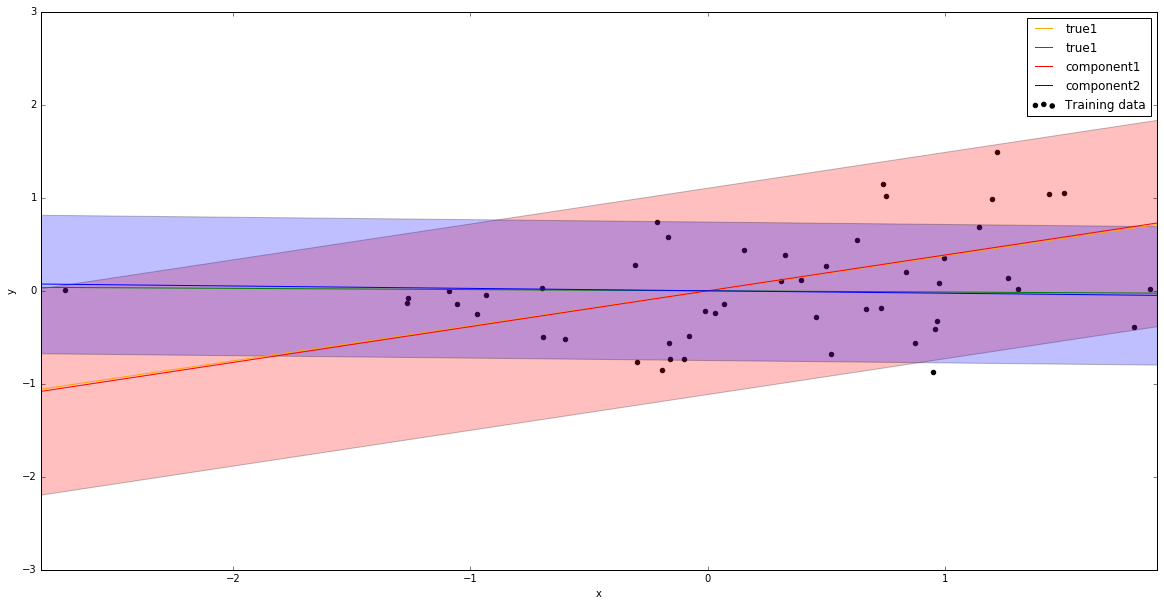

In [980]:
# if possible, plot samples, true model and estimated model
if pdata == 1:
    plt.figure(figsize=(20,10))
    plt.scatter(X, Y, s=20, c='black', label="Training data")
#         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
    x = arange(min(X)-0.1, max(X)+0.1, 0.1)
#         print_linear_model(x, true_model.get_p()["phi"], \
#                 true_model.get_p()["sigma2"], 'red', "True model")
#         print_linear_model(x, model.get_p()["phi"], \
#                 model.get_p()["sigma2"], 'blue', "Predicted model")

    y = true_model.p["phi_1"] * x
    color = 'orange'
    plt.plot(x, y, color, label="true1")
#     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_1"]), y - 1.96 * sqrt(true_model.p["sigma2_1"]), alpha=0.1, facecolor=color, interpolate=True)
    
    y = true_model.p["phi_2"] * x
    color = 'green'
    plt.plot(x, y, color, label="true1")
#     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_2"]), y - 1.96 * sqrt(true_model.p["sigma2_2"]), alpha=0.1, facecolor=color, interpolate=True)

    # Components
    y = model.L1.p["phi"] * x
    color = 'red'
    plt.plot(x, y, color, label="component1")
    plt.fill_between(x, y + 1.96 * sqrt(model.L1.p["sigma2"]), y - 1.96 * sqrt(model.L1.p["sigma2"]), alpha=0.25, facecolor=color, interpolate=True)

    y = model.L2.p["phi"] * x
    color = 'blue'
    plt.plot(x, y, color, label="component2")
    plt.fill_between(x, y + 1.96 * sqrt(model.L2.p["sigma2"]), y - 1.96 * sqrt(model.L2.p["sigma2"]), alpha=0.25, facecolor=color, interpolate=True)

    plt.legend(loc=1)
    plt.xlim(min(x), max(x))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [981]:
from numba import jit
import numpy as np

# @jit
def update_phi(responsibilities, Y, X, mu_phi0, sigma_phi0_inv):
    # responsibilities = gamma
    T = len(Y)
    P = X.shape[1]
    sum_gammayx = np.zeros(P)
    sum_gammaxx = np.zeros((P, P))
    gammax = np.zeros((T, P)) # gamma (1xT) elementwise* X (TxP) => gammax (TxP)
    
    for t in range(T):
        for p in range(P):
            sum_gammayx[p] += responsibilities[t] * Y[t] * X[t,p]
    
    for t in range(T):
        for p in range(P):
            gammax[t, p] += responsibilities[t] * X[t,p]
    
    for t in range(T):
        for p in range(p):
            sum_gammaxx[p] += gammax[t,p] * X[t,p]
        
#     sum_gammayx_o     = responsibilities.T.dot(Y * X)
#     sum_gammaxx_o     = np.dot( X.T, (responsibilities.T * X) )
#     print("sum_gammayx", sum_gammayx.shape, "sum_gammaxx", sum_gammaxx.shape)
    sigma_mu        = sigma_phi0_inv.dot(mu_phi0)
    sigma_phi_inv   = sigma_phi0_inv + sum_gammaxx
    return solve(sigma_phi_inv, sigma_mu + sum_gammayx)


def update_sigma_ml(phi, responsibilities, Y, X):
    T = len(Y)
    P = X.shape[1]
    
#     err = 0.0
#     for t in range(T):
#         for p in range(P):
#             err += responsibilities[t] * (Y[t] - phi[p]*X[t,p])**2

    err = 0.0
    for t in range(T):
        jup = 0.0
        for p in range(P):
            jup += phi[p]*X[t,p]
        err += responsibilities[t] * (Y[t] - jup)**2
        
#     phiX1 = phi.dot(X.T)
#     target_err1 = (Y - phiX1)**2
#     err1 = responsibilities.dot(target_err1)
#     old = err1/np.sum(responsibilities)
    new = err / np.sum(responsibilities)
#     print("SIGMA OLD NEW", old, new)
#     print("SIGMA DIFF", old-new)
    return new
#     return err / np.sum(responsibilities)
    

@jit
def update_phi_ml(responsibilities, Y, X):
    # responsibilities = gamma
    T = len(Y)
    P = X.shape[1]
    sum_gammayx = np.zeros(P)
    sum_gammaxx = np.zeros((P, P))
    gammax = np.zeros((T, P)) # gamma (1xT) elementwise* X (TxP) => gammax (TxP)
    
    for t in range(T):
        for p in range(P):
            sum_gammayx[p] += responsibilities[t] * Y[t] * X[t,p]
    
    for t in range(T):
        for p in range(P):
            gammax[t, p] += responsibilities[t] * X[t,p]
            
#     foobuz = X.T.dot(gammax)
#     print(foobuz)
    
    for t in range(T): # x^T cdot gammax -> PxP
        for p1 in range(P):
            for p2 in range(P):
                sum_gammaxx[p1,p2] += X[t,p1] * gammax[t,p2]
    
#     print("X SHAPE", X.shape, "Y SHAPE", Y.shape, "GAMMA SHAPE", responsibilities.shape)
    
#     sum_gammayx_1 = responsibilities.T.dot( (Y * X.T).T )
#     sum_gammaxx_1 = np.dot( X.T, (responsibilities * X.T).T )
#     print("sum_gammayx_1", sum_gammayx_1.shape, "sum_gammaxx_1", sum_gammaxx_1.shape)
#     sum_gammayx_o     = responsibilities.T.dot(Y * X)
#     sum_gammaxx_o     = np.dot( X.T, (responsibilities.T * X) )
#     print("sum_gammayx", sum_gammayx.shape, "sum_gammaxx", sum_gammaxx.shape)
#     print("sum_gammayx", sum_gammayx)
#     print("sum_gammaxx", sum_gammaxx)
#     print("TESTDIFF", sum_gammaxx_1 - foobuz)
#     print("DIFF SUM YX", np.sum(sum_gammayx - sum_gammayx_1))
#     print("DIFF SUM XX", np.sum(sum_gammaxx - sum_gammaxx_1))
#     print("DIFF YX", sum_gammayx - sum_gammayx_1)
#     print("DIFF XX", sum_gammaxx - sum_gammaxx_1)
    return solve(sum_gammaxx, sum_gammayx)

# @jit
# def update_phi(responsibilities, Y, X, mu_phi0, sigma_phi0_inv):
#     # responsibilities = gamma
#     sum_gammayx     = responsibilities.T.dot(Y * X)
#     sum_gammaxx     = np.dot( X.T, (responsibilities.T * X) )
#     sigma_mu        = sigma_phi0_inv.dot(mu_phi0)
#     sigma_phi_inv   = sigma_phi0_inv + sum_gammaxx
#     return solve(sigma_phi_inv, sigma_mu + sum_gammayx)

In [982]:
jeje = np.array([1,2,3,4.0])

In [983]:
jeje**2

array([  1.,   4.,   9.,  16.])

In [984]:
class EM_algo_MM_ML(EM_algo):
    """
        A mixture of two linear models, ML instead of MAP.
    """

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.alpha_w0       = self.h["alpha_w0"]
        self.beta_w0        = self.h["beta_w0"]

        # Same priors for phi1 and phi2, s2_1, s2_2, don't bother to copy vars twice
        # i.e. alpha_s2_1_0 = alpha_s2_2_0 = alpha_s20
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]
        
        # initial parameter estimates drawn from prior
        self.p             = dict()
        # Weights
        self.p["w"]        = beta(self.alpha_w0, self.beta_w0)
        # Responsibilities (TODO: do we need this here?)
        self.p["gamma"]    = binomial(1, self.p["w"], self.ndata)
#         print("INIT GAMMA TYPE", type(self.p["gamma"]))
#         print("INIT GAMMA SHAPE", self.p["gamma"].shape)
        # Component 1
        self.p["sigma2_1"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi_1"]    = mvnormal(self.mu_phi0, self.p["sigma2_1"] * self.sigma_phi0)
#         print("INIT PHI1 SHAPE", self.p["phi_1"].shape)
        # Component 2
        self.p["sigma2_2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi_2"]    = mvnormal(self.mu_phi0, self.p["sigma2_2"] * self.sigma_phi0)
        
        if not self.X is None and not self.Y is None:
            self.current_ilogl, self.icll = self.incompletelogl()


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value and z-value
        """
        mean1 = float(item.dot(self.p["phi_1"]))
        std1  = sqrt(self.p["sigma2_1"])
        mean2 = float(item.dot(self.p["phi_2"]))
        std2  = sqrt(self.p["sigma2_2"])
        
        if np.random.rand() < self.p["w"]:
            return normal(mean1, std1), 1
        else:
            return normal(mean2, std2), 2


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        
#         return self.incompletelogl()
                
        ll         = zeros(4)
#         phi_1_diff = self.p["phi_1"] - self.mu_phi0
# #         print("phi_1_diff", phi_1_diff.shape)
#         phi_2_diff = self.p["phi_2"] - self.mu_phi0
#         phi_1_err  = phi_1_diff.T.dot(phi_1_diff)
# #         print("phi_1_err", phi_1_err.shape)
#         phi_2_err  = phi_2_diff.T.dot(phi_2_diff)
# #         err_1      = (self.X.dot(self.p["phi_1"]) - self.Y) ** 2
# #         err_2      = (self.X.dot(self.p["phi_2"]) - self.Y) ** 2
# #         print("phi1", self.p["phi_1"].shape)
#         err_1      = (self.Y - self.X.dot(self.p["phi_1"])) ** 2
# #         print("err", err_1.shape)
# #         print("self.Y", self.Y.shape, Y.shape)
# #         print("self.X.dot(self.p[phi_1])", self.X.dot(self.p["phi_1"]).shape)
#         err_2      = (self.Y - self.X.dot(self.p["phi_2"])) ** 2
        
        # Responsibilities
#         propto_gamma1 =      self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
#         gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
        gamma = self.p["gamma"]
    
#         ll[0] = log(self.p["w"]) * np.sum(gamma)
        ll[1] = gamma.dot(norm.logpdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"])))
#         ll[2] = log(1-self.p["w"]) * np.sum(1-gamma)
        ll[3] = gamma.dot(norm.logpdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"])))
        
        ### posterior factorizes p(y,z,w,phi,sigma) = p(y)p(z)p(w)p(phi)p(sigma)
        
        ### p(y)
#         ll[0] = self.p["w"]       * (-0.5 * log(2 * pi * self.p["sigma2_1"]) * self.ndata)
#         ll[1] = self.p["w"]       * np.sum(- 0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = (1 - self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_2"]) * self.ndata)
#         ll[3] = (1 - self.p["w"]) * np.sum(- 0.5 * err_2 / self.p["sigma2_2"])

#         wN1 =    gamma  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         wN2 = (1-gamma) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
#         ll[0] = np.sum( log( wN1 + wN2 ) )

#         ll[0] =       gamma.dot(-0.5 * log(2 * pi * self.p["sigma2_1"]) -0.5 * err_1 / self.p["sigma2_1"])
#         ll[1] = 0
#         ll[2] = (1 - gamma).dot(-0.5 * log(2 * pi * self.p["sigma2_2"]) -0.5 * err_2 / self.p["sigma2_2"])
#         ll[3] = 0

#         ll[0] = -0.5 * log(2 * pi * self.p["sigma2_1"]) * np.sum(gamma)
#         ll[1] = gamma.dot(-0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = -0.5 * log(2 * pi * self.p["sigma2_2"]) * np.sum(1 - gamma)
#         ll[3] = (1 - gamma).dot(-0.5 * err_2 / self.p["sigma2_2"])

#         ll[0] = log(self.p["w"]) * np.sum(gamma) - 0.5 * log(2 * pi * self.p["sigma2_1"]) * np.sum(gamma)
#         ll[1] = gamma.dot(-0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = log(1-self.p["w"]) * np.sum(1-gamma) - 0.5 * log(2 * pi * self.p["sigma2_2"]) * np.sum(1 - gamma)
#         ll[3] = (1 - gamma).dot(-0.5 * err_2 / self.p["sigma2_2"])
 
        return np.sum(ll), ll


    def incompletelogl(self):
        """
            Calculates the incomplete data log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll         = zeros(20)
        phi_1_diff = self.p["phi_1"] - self.mu_phi0
        phi_2_diff = self.p["phi_2"] - self.mu_phi0
        phi_1_err  = phi_1_diff.T.dot(phi_1_diff)
        phi_2_err  = phi_2_diff.T.dot(phi_2_diff)
        err_1      = (self.X.dot(self.p["phi_1"]) - self.Y) ** 2
        err_2      = (self.X.dot(self.p["phi_2"]) - self.Y) ** 2

        #         propto_gamma1 = np.zeros(self.ndata)
#         for t in range(self.ndata):
#             propto_gamma1[t] = self.p["w"] * 1/(sqrt(2*pi*self.p["sigma2_1"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_1"].dot(X[t].T))**2)/self.p["sigma2_1"])
#         propto_gamma2 = np.zeros(self.ndata)
#         for t in range(self.ndata):
#             propto_gamma2[t] = (1-self.p["w"]) * 1/(sqrt(2*pi*self.p["sigma2_2"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_2"].dot(X[t].T))**2)/self.p["sigma2_2"])
        
        ### p(y)
#         wN1 = np.zeros(self.ndata)
#         for t in range(self.ndata):
#             wN1 +=    self.p["w"]  * 1/(sqrt(2*pi*self.p["sigma2_1"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_1"].dot(X[t].T))**2)/self.p["sigma2_1"])
#         wN2 = np.zeros(self.ndata)
#         for t in range(self.ndata):
#             wN2 += (1-self.p["w"]) * 1/(sqrt(2*pi*self.p["sigma2_2"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_2"].dot(X[t].T))**2)/self.p["sigma2_2"])
#         wN1 =    self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         wN2 = (1-self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))

#         wN1 = norm.logpdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         wN2 = norm.logpdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
#         ll[0] = log(self.p["w"]) * self.ndata + log(1-self.p["w"]) * self.ndata
#         ll[1] = np.sum( wN1 + wN2 )

        N1 = norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
        N2 = norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
        ll[0] = log(self.p["w"]) * self.ndata + log(1-self.p["w"]) * self.ndata
        ll[1] = np.sum( np.log( self.p["w"]*N1 + (1-self.p["w"])*N2 ) )

#         ll[0] =     log(self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_1"]) * self.ndata)
#         ll[1] =     log(self.p["w"]) * np.sum(- 0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = log(1 - self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_2"]) * self.ndata)
#         ll[3] = log(1 - self.p["w"]) * np.sum(- 0.5 * err_2 / self.p["sigma2_2"])

#         ll[0] = self.p["w"]       * (-0.5 * log(2 * pi * self.p["sigma2_1"]) * self.ndata)
#         ll[1] = self.p["w"]       * np.sum(- 0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = (1 - self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_2"]) * self.ndata)
#         ll[3] = (1 - self.p["w"]) * np.sum(- 0.5 * err_2 / self.p["sigma2_2"])
        
        return np.sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        
#         Y = self.Y.view()
#         Y.shape = (self.ndata, 1) # set Y view shape

        # ==================== E-STEP ====================

        # ========== Responsibilities gamma ==========        
        # norm.pdf works on a vector, returning probability for each separately
        propto_gamma1 =      self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
        propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
        
#         propto_gamma1 = np.zeros(self.ndata)
#         for t in range(self.ndata):
#             propto_gamma1[t] = self.p["w"] * 1/(sqrt(2*pi*self.p["sigma2_1"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_1"].dot(X[t].T))**2)/self.p["sigma2_1"])
#         propto_gamma2 = np.zeros(self.ndata)
#         for t in range(self.ndata):
#             propto_gamma2[t] = (1-self.p["w"]) * 1/(sqrt(2*pi*self.p["sigma2_2"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_2"].dot(X[t].T))**2)/self.p["sigma2_2"])
        
#         print("propto_gamma1", propto_gamma1.shape, "propto_gamma2", propto_gamma2.shape)
#         print("propto_gamma1_x", propto_gamma1_x.shape, "propto_gamma2_x", propto_gamma2_x.shape)
#         print(np.sum(propto_gamma1 - propto_gamma1_x), np.sum(propto_gamma2 - propto_gamma2_x))
#         print("n", propto_gamma1 > 1.0)
#         print("x", propto_gamma1_x > 1.0)
#         print(propto_gamma1)
#         print(propto_gamma1_x)
        # elementwise, works because numpy
        gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
#         print("gamma", gamma.shape)
#         gammaView = gamma.view()
#         gammaView.shape = (1, self.ndata)
#         print("gammaView.shape", gammaView.shape)
        self.p["gamma"] = gamma
#         sum_gamma = np.sum(gamma)
#         print("SUM_GAMMA SHAPE", sum_gamma.shape)
#         print("sum gamma", sum_gamma, "sum gamma+(1-gamma)", np.sum(gamma+(1-gamma)))
#         print("GAMMA TYPE", type(self.p["gamma"]))
#         print("GAMMA SHAPE", self.p["gamma"].shape)
        

        # ==================== M-STEP ====================

        # ========== Component weights w ==========
        self.p["w"] = sum(gamma) / self.ndata

#         print("= W INCOMPLETE LL DEBUG =")
#         newlogl, ill = self.incompletelogl()
#         self.debug_logl(self.icll, ill)
#         print("= END W INCOMPLETE LL DEBUG =")
#         print("W LL DEBUG")
#         newlogl, ll = self.logl()
#         self.debug_logl(self.cll, ll)
        self.assert_logl_increased("w")
        
        
#         # ========== Variables phi ==========
        
        
        # phi_1
        blug = eye(self.ndata) * gamma
        flup = X.T.dot(blug.dot(X))
        sum_gammayx = gamma.T.dot( (Y * self.X.T).T )
        self.p["phi_1"] = solve(flup, sum_gammayx)
#         self.p["phi_1"] = update_phi_ml(gamma, self.Y, self.X)
#         sum_gammayx = gamma.T.dot( (Y * self.X.T).T )
#         sum_gammaxx = np.dot( X.T, (gamma * X.T).T )
#         self.p["phi_1"] = solve(sum_gammaxx, sum_gammayx)
        
        self.assert_logl_increased("phi_1")
        
        
        # phi_2
        blug = eye(self.ndata) * (1-gamma)
        flup = X.T.dot(blug.dot(X))
        sum_gammayx = (1-gamma).T.dot( (Y * self.X.T).T )
        self.p["phi_2"] = solve(flup, sum_gammayx)
#         self.p["phi_2"] = update_phi_ml((1-gamma), self.Y, self.X)
#         sum_gammayx = (1-gamma).T.dot(  (Y * self.X.T).T  )
#         sum_gammaxx = np.dot( X.T, ((1-gamma) * X.T).T )
#         self.p["phi_2"] = solve(sum_gammaxx, sum_gammayx)
        
        self.assert_logl_increased("phi_2")


        # ========== Variances sigma2 ==========
        
        # sigma2_1
#         self.p["sigma2_1"] = update_sigma_ml(self.p["phi_1"], gamma, self.Y, self.X)
#         phie = np.sum((self.p["phi_1"] - self.mu_phi0) ** 2)  / self.lbd_phi0
        phiX = self.p["phi_1"].dot(self.X.T)
        target_err = (self.Y - phiX)**2
        err = gamma.dot(target_err)
        num = err
        den = np.sum(gamma)
#         den = 2*self.alpha_s20 + 2.0 + np.sum(gamma) + self.pdata
        self.p["sigma2_1"] = num / den
#         print("phie", phie.shape, "phiX.shape", phiX.shape, "target_err", target_err.shape, "err", err.shape, "num", num.shape, "den", den.shape)
        if self.p["sigma2_1"] < 0.0:
            raise ValueError("sigma2_1 < 0.0")
        
        # compare ratios
#         print("phie/P", phie/self.pdata, "phie", phie, "err/sumGamma", err/np.sum(gamma), "err", err)
        
        self.assert_logl_increased("sigma2_1")
        
        # sigma2_2
#         self.p["sigma2_2"] = update_sigma_ml(self.p["phi_2"], (1-gamma), self.Y, self.X)
#         phie = np.sum((self.p["phi_2"] - self.mu_phi0) ** 2)  / self.lbd_phi0
        phiX = self.p["phi_2"].dot(self.X.T)
        target_err = (self.Y - phiX)**2
        err = (1-gamma).dot(target_err)
        num = err
        den = np.sum(1-gamma)
        self.p["sigma2_2"] = num / den
#         print("phie", phie.shape, "phiX.shape", phiX.shape, "target_err", target_err.shape, "err", err.shape, "num", num.shape, "den", den.shape)
        if self.p["sigma2_2"] < 0.0:
            raise ValueError("sigma2_2 < 0.0")
        
        # compare ratios
#         print("phie/P", phie/self.pdata, "phie", phie, "err/sum1-Gamma", err/np.sum(1-gamma), "err", err)


        self.assert_logl_increased("sigma2_2")
#         self.assert_logl_increased("sigma2 update")    
        
#         print("SIGMA LL DEBUG")
#         newlogl, ll = self.logl()
#         self.debug_logl(self.cll, ll)
        
#         # if possible, plot samples, true model and estimated model
#         if self.pdata == 1:
#             plt.figure(figsize=(20,10))
#             plt.scatter(self.X, self.Y, s=20, c='black', label="Training data")
#     #         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
#             x = arange(min(self.X)-0.1, max(self.X)+0.1, 0.1)
#     #         print_linear_model(x, true_model.get_p()["phi"], \
#     #                 true_model.get_p()["sigma2"], 'red', "True model")
#     #         print_linear_model(x, model.get_p()["phi"], \
#     #                 model.get_p()["sigma2"], 'blue', "Predicted model")
#             y = self.p["phi_1"] * x
#             color = 'red'
#             plt.plot(x, y, color, label="component1")
#             plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_1"]), y - 1.96 * sqrt(self.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)
            
#             y = self.p["phi_2"] * x
#             color = 'blue'
#             plt.plot(x, y, color, label="component2")
#             plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_2"]), y - 1.96 * sqrt(self.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

#             plt.legend(loc=1)
#             plt.xlim(min(x), max(x))
#             plt.xlabel("x")
#             plt.ylabel("y")
#             plt.show()
#             input("Press Enter to continue...")
        
        #print("w", self.p["w"], "phi_1", self.p["phi_1"], "phi_2", self.p["phi_2"], "s2_1", self.p["sigma2_1"], "s2_2", self.p["sigma2_2"])


In [1007]:
class EM_algo_MM(EM_algo):
    """
        A mixture of two linear models.
    """

    def reset(self):
        """
            Reset priors and draw parameter estimates from prior.
        """
        # priors
        self.alpha_w0       = self.h["alpha_w0"]
        self.beta_w0        = self.h["beta_w0"]

        # Same priors for phi1 and phi2, s2_1, s2_2, don't bother to copy vars twice
        # i.e. alpha_s2_1_0 = alpha_s2_2_0 = alpha_s20
        self.lbd_phi0       = self.h["lbd_phi0"]
        self.alpha_s20      = self.h["alpha_s20"]
        self.beta_s20       = self.h["beta_s20"]
        self.sigma_phi0     = eye(self.pdata) * self.h["lbd_phi0"]
        self.sigma_phi0_inv = eye(self.pdata) / self.h["lbd_phi0"]
        self.mu_phi0        = ones(self.pdata) * self.h["mu_phi0"]
        
        # Precalculations:
#         self.w_gamma_ln_multiplier  = gammaln(self.alpha_w0 + self.beta_w0) - gammaln(self.alpha_w0) - gammaln(self.beta_w0)
        self.w_gamma_ln_multiplier  = log(gamma(self.alpha_w0 + self.beta_w0)) - log(gammaln(self.alpha_w0)) - log(gammaln(self.beta_w0))
#         self.w_gamma_ln_multiplier -= gammaln(self.alpha_w0)
#         self.w_gamma_ln_multiplier -= gammaln(self.beta_w0)
        
        
        # initial parameter estimates drawn from prior
        self.p             = dict()
        # Weights
        self.p["w"]        = beta(self.alpha_w0, self.beta_w0)
        # Responsibilities (TODO: do we need this here?)
        self.p["gamma"]    = binomial(1, self.p["w"], self.ndata)
#         print("INIT GAMMA TYPE", type(self.p["gamma"]))
#         print("INIT GAMMA SHAPE", self.p["gamma"].shape)
        # Component 1
        self.p["sigma2_1"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi_1"]    = mvnormal(self.mu_phi0, self.p["sigma2_1"] * self.sigma_phi0)
#         print("INIT PHI1 SHAPE", self.p["phi_1"].shape)
        # Component 2
        self.p["sigma2_2"] = 1.0 / gamma(self.alpha_s20, 1.0 / self.beta_s20) # inverse gamma
        self.p["phi_2"]    = mvnormal(self.mu_phi0, self.p["sigma2_2"] * self.sigma_phi0)
        
        if not self.X is None and not self.Y is None:
            self.current_ilogl, self.icll = self.incompletelogl()
        
#         print("START w", self.p["w"])
#         print("START phi_1", self.p["phi_1"])
#         print("START sigma2_1", self.p["sigma2_1"])
#         print("START phi_2", self.p["phi_2"])
#         print("START sigma2_2", self.p["sigma2_2"])


    def draw(self, item):
        """
            Draw a data sample from the current predictive distribution.
            Returns the y-value and z-value
        """
        mean1 = float(item.dot(self.p["phi_1"]))
        std1  = sqrt(self.p["sigma2_1"])
        mean2 = float(item.dot(self.p["phi_2"]))
        std2  = sqrt(self.p["sigma2_2"])
        
        if np.random.rand() < self.p["w"]:
            return normal(mean1, std1), 1
        else:
            return normal(mean2, std2), 2


    def logl(self):
        """
            Calculates the full log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        
        return self.incompletelogl()
        
#         phie  = self.p["phi"] - self.mu_phi0
#         err   = (self.X.dot(self.p["phi"]) - self.Y) ** 2
#         # p(y)
#         ll[0] = - 0.5 * log(2 * pi * self.p["sigma2"]) * self.ndata
#         ll[1] = sum(- 0.5 * err / self.p["sigma2"])
#         # p(phi)
#         ll[2] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2"]) * self.pdata
#         ll[3] = - 0.5 * phie.T.dot(phie) / (self.lbd_phi0 * self.p["sigma2"])
#         # p(sigma2)
#         ll[4] = self.alpha_s20 * log(self.beta_s20)
#         ll[5] = - gammaln(self.alpha_s20)
#         ll[6] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2"])
#         ll[7] = - self.beta_s20 / self.p["sigma2"]
        
        ll         = zeros(20)
        phi_1_diff = self.p["phi_1"] - self.mu_phi0
#         print("phi_1_diff", phi_1_diff.shape)
        phi_2_diff = self.p["phi_2"] - self.mu_phi0
        phi_1_err  = phi_1_diff.T.dot(phi_1_diff)
#         print("phi_1_err", phi_1_err.shape)
        phi_2_err  = phi_2_diff.T.dot(phi_2_diff)
#         err_1      = (self.X.dot(self.p["phi_1"]) - self.Y) ** 2
#         err_2      = (self.X.dot(self.p["phi_2"]) - self.Y) ** 2
#         print("phi1", self.p["phi_1"].shape)
        err_1      = (self.Y - self.X.dot(self.p["phi_1"])) ** 2
#         print("err", err_1.shape)
#         print("self.Y", self.Y.shape, Y.shape)
#         print("self.X.dot(self.p[phi_1])", self.X.dot(self.p["phi_1"]).shape)
        err_2      = (self.Y - self.X.dot(self.p["phi_2"])) ** 2
        
        # Responsibilities
#         propto_gamma1 =      self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         propto_gamma2 = (1 - self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
#         gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
        gamma = self.p["gamma"]
        
        ### posterior factorizes p(y,z,w,phi,sigma) = p(y)p(z)p(w)p(phi)p(sigma)
        
        ### p(y)
#         ll[0] = self.p["w"]       * (-0.5 * log(2 * pi * self.p["sigma2_1"]) * self.ndata)
#         ll[1] = self.p["w"]       * np.sum(- 0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = (1 - self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_2"]) * self.ndata)
#         ll[3] = (1 - self.p["w"]) * np.sum(- 0.5 * err_2 / self.p["sigma2_2"])

#         wN1 =    gamma  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         wN2 = (1-gamma) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
#         ll[0] = np.sum( log( wN1 + wN2 ) )

#         ll[0] =       gamma.dot(-0.5 * log(2 * pi * self.p["sigma2_1"]) -0.5 * err_1 / self.p["sigma2_1"])
#         ll[1] = 0
#         ll[2] = (1 - gamma).dot(-0.5 * log(2 * pi * self.p["sigma2_2"]) -0.5 * err_2 / self.p["sigma2_2"])
#         ll[3] = 0

        ll[0] = -0.5 * log(2 * pi * self.p["sigma2_1"]) * np.sum(gamma)
        ll[1] = gamma.dot(-0.5 * err_1 / self.p["sigma2_1"])
        ll[2] = -0.5 * log(2 * pi * self.p["sigma2_2"]) * np.sum(1 - gamma)
        ll[3] = (1 - gamma).dot(-0.5 * err_2 / self.p["sigma2_2"])

#         ll[0] = log(self.p["w"]) * np.sum(gamma) - 0.5 * log(2 * pi * self.p["sigma2_1"]) * np.sum(gamma)
#         ll[1] = gamma.dot(-0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = log(1-self.p["w"]) * np.sum(1-gamma) - 0.5 * log(2 * pi * self.p["sigma2_2"]) * np.sum(1 - gamma)
#         ll[3] = (1 - gamma).dot(-0.5 * err_2 / self.p["sigma2_2"])
 
        
        ### p(z)
#         ll[4] = np.sum((gamma * log(self.p["w"])) + ((1 - gamma) * log(1 - self.p["w"])))
        
        ### p(w)
        ll[5] = self.w_gamma_ln_multiplier
        ll[6] = (self.alpha_w0 - 1) * self.p["w"]
        ll[7] = (self.beta_w0  - 1) * (1 - self.p["w"])
        
        ### p(phi)
        # phi_1
        ll[8]  = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2_1"]) * self.pdata
        ll[9]  = - 0.5 * phi_1_err / (self.lbd_phi0 * self.p["sigma2_1"])
        # phi_2
        ll[10] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2_2"]) * self.pdata
        ll[11] = - 0.5 * phi_2_err / (self.lbd_phi0 * self.p["sigma2_2"])
        
        ### p(sigma2)
        # sigma2_1
        ll[12] = self.alpha_s20 * log(self.beta_s20)
        ll[13] = - gammaln(self.alpha_s20)
        ll[14] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2_1"])
        ll[15] = - self.beta_s20 / self.p["sigma2_1"]
        # sigma2_2
        ll[16] = self.alpha_s20 * log(self.beta_s20)
        ll[17] = - gammaln(self.alpha_s20)
        ll[18] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2_2"])
        ll[19] = - self.beta_s20 / self.p["sigma2_2"]
        
        return np.sum(ll), ll


    def incompletelogl(self):
        """
            Calculates the incomplete data log likelihood for this model.
            Returns the logl (and the values of each term for debugging purposes)
        """
        ll         = zeros(20)
        phi_1_diff = self.p["phi_1"] - self.mu_phi0
        phi_2_diff = self.p["phi_2"] - self.mu_phi0
        phi_1_err  = phi_1_diff.T.dot(phi_1_diff)
        phi_2_err  = phi_2_diff.T.dot(phi_2_diff)
#         err_1      = (self.X.dot(self.p["phi_1"]) - self.Y) ** 2
#         err_2      = (self.X.dot(self.p["phi_2"]) - self.Y) ** 2
        
        ### p(y)
        N1 = norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
        N2 = norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
        ll[1] = np.sum( np.log( self.p["w"]*N1 + (1-self.p["w"])*N2 ) )
        
#         wN1 =    self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         wN2 = (1-self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
#         ll[0] = np.sum( log( wN1 + wN2 ) )
        
#         ll[0] = self.p["w"]       * (-0.5 * log(2 * pi * self.p["sigma2_1"]) * self.ndata)
#         ll[1] = self.p["w"]       * np.sum(- 0.5 * err_1 / self.p["sigma2_1"])
#         ll[2] = (1 - self.p["w"]) * (-0.5 * log(2 * pi * self.p["sigma2_2"]) * self.ndata)
#         ll[3] = (1 - self.p["w"]) * np.sum(- 0.5 * err_2 / self.p["sigma2_2"])
 
        ### p(z)
#         gamma = self.p["gamma"]
#         ll[4] = np.sum((gamma * log(self.p["w"])) + ((1 - gamma) * log(1 - self.p["w"])))
        ll[4] = 0
        
        ### p(w)
        ll[5] = self.w_gamma_ln_multiplier
        ll[6] = (self.alpha_w0 - 1) * self.p["w"]
        ll[7] = (self.beta_w0  - 1) * (1 - self.p["w"])
        
        ### p(phi)
        # phi_1
        ll[8]  = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2_1"]) * self.pdata
        ll[9]  = - 0.5 * phi_1_err / (self.lbd_phi0 * self.p["sigma2_1"])
        # phi_2
        ll[10] = - 0.5 * log(2 * pi * self.lbd_phi0 * self.p["sigma2_2"]) * self.pdata
        ll[11] = - 0.5 * phi_2_err / (self.lbd_phi0 * self.p["sigma2_2"])
        
        ### p(sigma2)
        # sigma2_1
        ll[12] = self.alpha_s20 * log(self.beta_s20)
        ll[13] = - gammaln(self.alpha_s20)
        ll[14] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2_1"])
        ll[15] = - self.beta_s20 / self.p["sigma2_1"]
        # sigma2_2
        ll[16] = self.alpha_s20 * log(self.beta_s20)
        ll[17] = - gammaln(self.alpha_s20)
        ll[18] = - (self.alpha_s20 + 1.0) * log(self.p["sigma2_2"])
        ll[19] = - self.beta_s20 / self.p["sigma2_2"]
        
        return np.sum(ll), ll


    def EM_iter(self):
        """
            Executes a single round of EM updates for this model.

            Has checks to make sure that updates increase logl and
            that parameter values stay in sensible limits.
        """
        
#         Y = self.Y.view()
#         Y.shape = (self.ndata, 1) # set Y view shape

        # ==================== E-STEP ====================

        # ========== Responsibilities gamma ==========        
        # norm.pdf works on a vector, returning probability for each separately
#         propto_gamma1_x =      self.p["w"]  * norm.pdf(self.Y, self.X.dot(self.p["phi_1"]), sqrt(self.p["sigma2_1"]))
#         propto_gamma2_x = (1 - self.p["w"]) * norm.pdf(self.Y, self.X.dot(self.p["phi_2"]), sqrt(self.p["sigma2_2"]))
        
        propto_gamma1 = np.zeros(self.ndata)
        for t in range(self.ndata):
            propto_gamma1[t] = self.p["w"] * 1/(sqrt(2*pi*self.p["sigma2_1"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_1"].dot(X[t].T))**2)/self.p["sigma2_1"])
        propto_gamma2 = np.zeros(self.ndata)
        for t in range(self.ndata):
            propto_gamma2[t] = (1-self.p["w"]) * 1/(sqrt(2*pi*self.p["sigma2_2"])) * np.exp(-0.5 * ((self.Y[t] - self.p["phi_2"].dot(X[t].T))**2)/self.p["sigma2_2"])
        
#         print("propto_gamma1", propto_gamma1.shape, "propto_gamma2", propto_gamma2.shape)
#         print("propto_gamma1_x", propto_gamma1_x.shape, "propto_gamma2_x", propto_gamma2_x.shape)
#         print(np.sum(propto_gamma1 - propto_gamma1_x), np.sum(propto_gamma2 - propto_gamma2_x))
#         print("n", propto_gamma1 > 1.0)
#         print("x", propto_gamma1_x > 1.0)
#         print(propto_gamma1)
#         print(propto_gamma1_x)
        # elementwise, works because numpy
        gamma = propto_gamma1 / (propto_gamma1 + propto_gamma2)
#         print("gamma", gamma.shape)
#         gammaView = gamma.view()
#         gammaView.shape = (1, self.ndata)
#         print("gammaView.shape", gammaView.shape)
        self.p["gamma"] = gamma
        sum_gamma = np.sum(gamma)
#         print("sum gamma", sum_gamma, "sum gamma+(1-gamma)", np.sum(gamma+(1-gamma)))
#         print("GAMMA TYPE", type(self.p["gamma"]))
#         print("GAMMA SHAPE", self.p["gamma"].shape)
        

        # ==================== M-STEP ====================

        # ========== Component weights w ==========
        num = 2*sum_gamma + self.alpha_w0 - 1
        den = 2*self.ndata + self.alpha_w0 + self.beta_w0 - 2
#         num = sum_gamma + self.alpha_w0 - 1
#         den = self.ndata + self.alpha_w0 + self.beta_w0 - 2
#         num = sum_gamma
#         den = self.ndata
        self.p["w"] = num / den

#         print("= W INCOMPLETE LL DEBUG =")
#         newlogl, ill = self.incompletelogl()
#         self.debug_logl(self.icll, ill)
#         print("= END W INCOMPLETE LL DEBUG =")
#         print("W LL DEBUG")
#         newlogl, ll = self.logl()
#         self.debug_logl(self.cll, ll)
        self.assert_logl_increased("w")
    
    
        # ========== Variances sigma2 ==========
        # phi_1 and phi_2 still have the previous value, i.e. from step s, we are calculating sigma for step s+1
        
        # sigma2_1
        phie = np.sum((self.p["phi_1"] - self.mu_phi0) ** 2)  / self.lbd_phi0
        phiX = self.p["phi_1"].dot(self.X.T)
        target_err = (self.Y - phiX)**2
        err = gamma.dot(target_err)
        num = 2*self.beta_s20 + err + phie
        den = 2*self.alpha_s20 + 2.0 + np.sum(gamma) + self.pdata
        self.p["sigma2_1"] = num / den
#         print("phie", phie.shape, "phiX.shape", phiX.shape, "target_err", target_err.shape, "err", err.shape, "num", num.shape, "den", den.shape)
        if self.p["sigma2_1"] < 0.0:
            raise ValueError("sigma2_1 < 0.0")
        
        # compare ratios
#         print("phie/P", phie/self.pdata, "phie", phie, "err/sumGamma", err/np.sum(gamma), "err", err)
        
#         self.assert_logl_increased("sigma2_1")
        
        # sigma2_2
        phie = np.sum((self.p["phi_2"] - self.mu_phi0) ** 2)  / self.lbd_phi0
        phiX = self.p["phi_2"].dot(self.X.T)
        target_err = (self.Y - phiX)**2
        err = (1-gamma).dot(target_err)
        num = 2*self.beta_s20 + err + phie
        den = 2*self.alpha_s20 + 2.0 + np.sum(1-gamma) + self.pdata
        self.p["sigma2_2"] = num / den
#         print("phie", phie.shape, "phiX.shape", phiX.shape, "target_err", target_err.shape, "err", err.shape, "num", num.shape, "den", den.shape)
        if self.p["sigma2_2"] < 0.0:
            raise ValueError("sigma2_2 < 0.0")
        
        # compare ratios
#         print("phie/P", phie/self.pdata, "phie", phie, "err/sum1-Gamma", err/np.sum(1-gamma), "err", err)


#         self.assert_logl_increased("sigma2_2")
#         self.assert_logl_increased("sigma2 update")    
        
#         print("SIGMA LL DEBUG")
#         newlogl, ll = self.logl()
#         self.debug_logl(self.cll, ll)
        
        
#         # ========== Variables phi ==========
        
        
        # phi_1
        sum_gammayx = gamma.T.dot( (Y * self.X.T).T )
#         sum_gammayx2 = gamma.T.dot(Y * self.X).T
#         gammaX = gammaView.T * X
#         print("GAMMAX SHAPE", gammaX.shape, "Y shape", Y.shape)
#         sum_gammayx3 = Y.T.dot(gammaX)
#         sum_gammayx4 = Y.T.dot(gammaX).T
#         print("CHECK1", sum_gammayx, sum_gammayx3, sum_gammayx3-sum_gammayx)
#         print("CHECK2", sum_gammayx.shape, sum_gammayx2.shape, sum_gammayx3.shape, sum_gammayx4.shape)
        # NEW
#         sum_gammaxx = np.dot( X.T, (gammaView.T * X) ) # WORKING
        sum_gammaxx = np.dot( X.T, (gamma * X.T).T )
#         sum_gammaxx = np.dot( X.T, (gammarep.T * X) )
        
#         sum_gammaxx = np.zeros([self.pdata,self.pdata])
#         print("gamma", gamma.shape)
#         for t in range(0,self.ndata):
#             sum_gammaxx += gamma[t] * np.dot(X[t].T, X[t])
# #         sum_gammaxx = gamma.T.dot((self.X * self.X))
        # END NEW
#         sigma_phi_inv = self.sigma_phi0_inv + sum_gammaxx
#         print("self.sigma_phi0_inv", self.sigma_phi0_inv.shape, "sigma_phi_inv", sigma_phi_inv.shape)
#         print("sum_gammayx, sum_gammaxx SHAPES", sum_gammayx.shape, sum_gammaxx.shape)
        sigma_mu        = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv   = self.sigma_phi0_inv + sum_gammaxx
        self.p["phi_1"] = solve(sigma_phi_inv, sigma_mu + sum_gammayx)
#         print("TEST 1", solve(sigma_phi_inv, sigma_mu + sum_gammayx), "TEST2", solve(sigma_phi_inv, sigma_mu + sum_gammayx2))
#         print("sum_gammaxx", sum_gammaxx.shape, "sum_gammaxy", sum_gammayx.shape, "sigma_mu", sigma_mu.shape, "sigma_phi_inv", sigma_phi_inv.shape)
#         print("phi_1", self.p["phi_1"])
        
#         self.assert_logl_increased("phi_1")
        
        
        # phi_2
        sum_gammayx = (1-gamma).T.dot(  (Y * self.X.T).T  )
#         sum_gammayx = Y.T.dot((1-gammaView).T * X)
        # NEW
        sum_gammaxx = np.dot( X.T, ((1-gamma) * X.T).T )
#         sum_gammaxx = np.dot( X.T, (one_minus_gammarep.T * X) )
        
#         sum_gammaxx = np.zeros([self.pdata,self.pdata])
#         for t in range(0,self.ndata):
#             sum_gammaxx += (1-gamma[t]) * np.dot(X[t].T, X[t])
#         # END NEW
# #         sum_gammaxx = (1-gamma).T.dot((self.X * self.X))
#         print("self.sigma_phi0_inv", self.sigma_phi0_inv.shape, "sigma_phi_inv", sigma_phi_inv.shape)
#         print("sum_gammayx, sum_gammaxx SHAPES", sum_gammayx.shape, sum_gammaxx.shape)
        sigma_mu        = self.sigma_phi0_inv.dot(self.mu_phi0)
        sigma_phi_inv   = self.sigma_phi0_inv + sum_gammaxx
        self.p["phi_2"] = solve(sigma_phi_inv, sigma_mu + sum_gammayx)
#         print("sum_gammaxx", sum_gammaxx.shape, "sum_gammaxy", sum_gammayx.shape, "sigma_mu", sigma_mu.shape, "sigma_phi_inv", sigma_phi_inv.shape)
#         print("phi_2", self.p["phi_2"])
        
#         print("PHI LL DEBUG")
#         newlogl, ll = self.logl()
#         self.debug_logl(self.cll, ll)
        self.assert_logl_increased("phi_2")


#         # ========== Variances sigma2 ==========
        
#         # sigma2_1
#         phie = np.sum((self.p["phi_1"] - self.mu_phi0) ** 2)  / self.lbd_phi0
#         phiX = self.p["phi_1"].dot(self.X.T)
#         target_err = (self.Y - phiX)**2
#         err = gamma.dot(target_err)
#         num = 2*self.beta_s20 + err + phie
#         den = 2*self.alpha_s20 + 2.0 + np.sum(gamma) + self.pdata
#         self.p["sigma2_1"] = num / den
# #         print("phie", phie.shape, "phiX.shape", phiX.shape, "target_err", target_err.shape, "err", err.shape, "num", num.shape, "den", den.shape)
#         if self.p["sigma2_1"] < 0.0:
#             raise ValueError("sigma2_1 < 0.0")
        
#         # compare ratios
# #         print("phie/P", phie/self.pdata, "phie", phie, "err/sumGamma", err/np.sum(gamma), "err", err)
        
#         self.assert_logl_increased("sigma2_1")
        
#         # sigma2_2
#         phie = np.sum((self.p["phi_2"] - self.mu_phi0) ** 2)  / self.lbd_phi0
#         phiX = self.p["phi_2"].dot(self.X.T)
#         target_err = (self.Y - phiX)**2
#         err = (1-gamma).dot(target_err)
#         num = 2*self.beta_s20 + err + phie
#         den = 2*self.alpha_s20 + 2.0 + np.sum(1-gamma) + self.pdata
#         self.p["sigma2_2"] = num / den
# #         print("phie", phie.shape, "phiX.shape", phiX.shape, "target_err", target_err.shape, "err", err.shape, "num", num.shape, "den", den.shape)
#         if self.p["sigma2_2"] < 0.0:
#             raise ValueError("sigma2_2 < 0.0")
        
#         # compare ratios
# #         print("phie/P", phie/self.pdata, "phie", phie, "err/sum1-Gamma", err/np.sum(1-gamma), "err", err)


#         self.assert_logl_increased("sigma2_2")
# #         self.assert_logl_increased("sigma2 update")    
        
# #         print("SIGMA LL DEBUG")
# #         newlogl, ll = self.logl()
# #         self.debug_logl(self.cll, ll)
        
#         # if possible, plot samples, true model and estimated model
#         if self.pdata == 1:
#             plt.figure(figsize=(20,10))
#             plt.scatter(self.X, self.Y, s=20, c='black', label="Training data")
#     #         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
#             x = arange(min(self.X)-0.1, max(self.X)+0.1, 0.1)
#     #         print_linear_model(x, true_model.get_p()["phi"], \
#     #                 true_model.get_p()["sigma2"], 'red', "True model")
#     #         print_linear_model(x, model.get_p()["phi"], \
#     #                 model.get_p()["sigma2"], 'blue', "Predicted model")
#             y = self.p["phi_1"] * x
#             color = 'red'
#             plt.plot(x, y, color, label="component1")
#             plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_1"]), y - 1.96 * sqrt(self.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)
            
#             y = self.p["phi_2"] * x
#             color = 'blue'
#             plt.plot(x, y, color, label="component2")
#             plt.fill_between(x, y + 1.96 * sqrt(self.p["sigma2_2"]), y - 1.96 * sqrt(self.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

#             plt.legend(loc=1)
#             plt.xlim(min(x), max(x))
#             plt.xlabel("x")
#             plt.ylabel("y")
#             plt.show()
#             input("Press Enter to continue...")
        
        #print("w", self.p["w"], "phi_1", self.p["phi_1"], "phi_2", self.p["phi_2"], "s2_1", self.p["sigma2_1"], "s2_2", self.p["sigma2_2"])


In [1008]:
# generate a model for estimating the parameters of the
# true model based on the observations (X, Y) we just made
# model = EM_algo_MM(hyperp, X, Y)
model = EM_algo_MM(hyperp, X, Y)
i, logl, r = model.EM_fit()
print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
        (logl, i, r))
print("")
print("MAP estimate of true model parameters:")
model.print_p()
print("")

Model fit (logl -34.68) after 73 iterations (alim reached)

MAP estimate of true model parameters:
phi_2 = [-0.74280749  0.06516523  0.46845568 -0.73660718  0.13075443  0.08773167
  0.55690992 -0.19581462  0.37689696 -0.39361115 -0.33104239 -0.13912593
 -0.46139462  0.01766988  0.15080123 -0.24216459 -0.48370614 -0.48219254
  0.10761102 -0.77278163 -0.21155728  0.08172795 -0.2304907   0.06264725
  0.6741262 ]
sigma2_1 = 0.0709366273502
sigma2_2 = 0.118233451188
w = 0.518835202255
phi_1 = [ 0.23215152 -0.18087002 -0.05732405  0.36762954 -0.02943917  0.33959919
 -0.09060954 -0.39791021  0.12459054 -0.23169578  0.0579912  -0.03857879
  0.15484226  0.06988388  0.53419598  0.06540299  0.29678898 -0.06121358
  0.2928115   0.41234414 -0.09940484  0.33034907  0.29313652 -0.61048573
  0.18847073]
gamma = [  6.31862084e-01   9.99978234e-01   1.53922674e-40   3.67770600e-02
   2.21037919e-27   5.46054985e-01   1.34640009e-11   1.00000000e+00
   2.75610021e-15   3.00240701e-05   9.99905848e-01   3

In [1005]:
# if possible, plot samples, true model and estimated model
if pdata == 1:
    plt.figure(figsize=(20,10))
    plt.scatter(X, Y, s=20, c='black', label="Training data")
#         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
    x = arange(min(X)-0.1, max(X)+0.1, 0.1)
#         print_linear_model(x, true_model.get_p()["phi"], \
#                 true_model.get_p()["sigma2"], 'red', "True model")
#         print_linear_model(x, model.get_p()["phi"], \
#                 model.get_p()["sigma2"], 'blue', "Predicted model")

    y = true_model.p["phi_1"] * x
    color = 'orange'
    plt.plot(x, y, color, label="true1")
#     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_1"]), y - 1.96 * sqrt(true_model.p["sigma2_1"]), alpha=0.1, facecolor=color, interpolate=True)
    
    y = true_model.p["phi_2"] * x
    color = 'green'
    plt.plot(x, y, color, label="true1")
#     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_2"]), y - 1.96 * sqrt(true_model.p["sigma2_2"]), alpha=0.1, facecolor=color, interpolate=True)

    # Components
    y = model.p["phi_1"] * x
    color = 'red'
    plt.plot(x, y, color, label="component1")
    plt.fill_between(x, y + 1.96 * sqrt(model.p["sigma2_1"]), y - 1.96 * sqrt(model.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)

    y = model.p["phi_2"] * x
    color = 'blue'
    plt.plot(x, y, color, label="component2")
    plt.fill_between(x, y + 1.96 * sqrt(model.p["sigma2_2"]), y - 1.96 * sqrt(model.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

    plt.legend(loc=1)
    plt.xlim(min(x), max(x))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [994]:
# get hyperparameters for model
hyperp = get_hyperp()
# generate 50 training data and 20 validation data locations of dim=1
ndata = 50
ndata_v = 50
pdata = 25
X = generate_X(ndata, pdata)
X_v = generate_X(ndata_v, pdata)

true_model = EM_algo_MM(hyperp, ndata=ndata, pdata=pdata)
Y, Z = generate_YZ(X, true_model)
Y_v, Z_v = generate_YZ(X_v, true_model)
print("Generated %d training data and %d validation data from true model:" % \
    (ndata, ndata_v))
true_model.print_p()
print("")

Generated 50 training data and 50 validation data from true model:
phi_2 = [ 0.14622796  0.17466192  0.23211332  0.02601663 -0.08892349  0.38066748
 -0.07461691 -0.37437487  0.0906503  -0.55028953  0.22270234 -0.07162377
 -0.04911523 -0.5516191   0.4399013  -0.07090167  0.21477018  0.09329735
  0.12188289  0.04177689  0.21079448  0.47410063  0.35316802 -0.49521044
 -0.28802884]
sigma2_1 = 0.17160297073388148
sigma2_2 = 0.1268152034792153
w = 0.3363261348567545
phi_1 = [-0.61782296  0.31023782 -0.60281633 -0.15913919  0.19062736  0.04071882
 -0.06026341 -0.33077767  0.08511221 -0.35964656 -0.1046024   0.5401076
 -0.7233217   0.22564523  0.17583085  0.05363284 -0.17044155 -0.61704558
 -0.0827809   0.27138255 -0.47140316 -0.75335157 -0.0873071   0.16622004
  0.30064356]
gamma = [1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1]



In [1009]:
mm_cumulative_error = 0.0
mm_max_diff = 0.0
foodict = {'w': 0, 'phi_1': 0, 'phi_2': 0, 'sigma2_1': 0, 'sigma2_2': 0}
bardict = {'w': 0, 'phi_1': 0, 'phi_2': 0, 'sigma2_1': 0, 'sigma2_2': 0}
counter = 0
counterOther = 0
counterAlim = 0
for truru in range(1000):
    try:
        # generate a model for estimating the parameters of the
        # true model based on the observations (X, Y) we just made
        model = EM_algo_MM(hyperp, X, Y)
        i, logl, r = model.EM_fit()
        if r == "alim":
            counterAlim += 1
#         print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
#                 (logl, i, r))
#         print("")
#         print("MAP estimate of true model parameters:")
#         model.print_p()
#         print("")
    except ValueError as e:
        counter = counter + 1
        foodict[str(e)] = foodict[str(e)] + 1
    except RuntimeError as e:
        counterOther = counterOther + 1
        bardict[str(e)] = bardict[str(e)] + 1

print(foodict)
print(counter, counterOther, counterAlim)
print(bardict)
print(mm_cumulative_error)
print(mm_max_diff)

{'phi_2': 0, 'w': 0, 'phi_1': 0, 'sigma2_2': 0, 'sigma2_1': 0}
0 0 1000
{'phi_2': 0, 'w': 0, 'phi_1': 0, 'sigma2_2': 0, 'sigma2_1': 0}
3.37453377128
0.00951989469854


In [ ]:
# {'phi_2': 0, 'w': 0, 'phi_1': 0, 'sigma2_2': 0, 'sigma2_1': 0}
# 0 205 795
# {'phi_2': 0, 'w': 0, 'phi_1': 0, 'sigma2_2': 94, 'sigma2_1': 111}
# 118.136238357
# 4.41033014787

In [493]:
workedParams = []
failedParams = []
workedW = []
failedW = []
workedPhi1 = []
failedPhi1 = []
workedPhi2 = []
failedPhi2 = []
workedSigma1 = []
failedSigma1 = []
workedSigma2 = []
failedSigma2 = []

In [494]:
for opop in range(1000):
    fail = False
    model = EM_algo_MM(hyperp, X, Y)
    try:
        for trara in range(1000):
            i, logl, r = model.EM_fit()
    except Exception as e:
        fail = True
        failedW.append(model.p["w"])
        failedPhi1.append(model.p["phi_1"])
        failedPhi2.append(model.p["phi_2"])
        failedSigma1.append(model.p["sigma2_1"])
        failedSigma2.append(model.p["sigma2_2"])
        failedParams.append([model.p["w"], model.p["phi_1"], model.p["phi_2"], model.p["sigma2_1"], model.p["sigma2_2"]])
    else:
        workedW.append(model.p["w"])
        workedPhi1.append(model.p["phi_1"])
        workedPhi2.append(model.p["phi_2"])
        workedSigma1.append(model.p["sigma2_1"])
        workedSigma2.append(model.p["sigma2_2"])
        workedParams.append([model.p["w"], model.p["phi_1"], model.p["phi_2"], model.p["sigma2_1"], model.p["sigma2_2"]])

In [496]:
len(workedW), len(failedW)

(349, 651)

In [901]:
yo = []
yo.extend([1,2,3])

In [902]:
yo

[1, 2, 3]

In [912]:
fupfup = []
fupfup.extend(np.array(failedW)[np.array(failedW) < 0.5])
fupfup.extend(np.array(failedW)[np.array(failedW) >= 0.5] - 0.5)
np.unique(np.array(fupfup).round(decimals=2))

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ])

In [516]:
np.unique(np.array(workedW).round(decimals=8)), np.unique(np.array(workedPhi1).round(decimals=8)), np.unique(np.array(workedPhi2).round(decimals=8)), np.unique(np.array(workedSigma1).round(decimals=8)), np.unique(np.array(workedSigma2).round(decimals=8))

(array([ 0.3126867 ,  0.31667702,  0.68332298,  0.6873133 ]),
 array([-0.34693938, -0.16985928,  0.18014518,  0.21157547]),
 array([-0.34693938, -0.16985928,  0.18014518,  0.21157547]),
 array([ 0.13873261,  0.20763594,  0.3472129 ,  0.4250252 ]),
 array([ 0.13873261,  0.20763594,  0.3472129 ,  0.4250252 ]))

In [512]:
# np.unique(np.array(workedW).round(decimals=8)), np.unique(np.array(failedW).round(decimals=8))

In [513]:
# np.unique(np.array(workedPhi1).round(decimals=8)), np.unique(np.array(failedPhi1).round(decimals=8))

In [514]:
# np.unique(np.array(workedPhi2).round(decimals=8)), np.unique(np.array(failedPhi2).round(decimals=8))

In [515]:
# np.unique(np.array(workedSigma1).round(decimals=8)), np.unique(np.array(failedSigma1).round(decimals=8))

In [488]:
# # plot failure states
# fail = False
# model = EM_algo_MM(hyperp, X, Y)
# try:
#     for trara in range(1000):
#         i, logl, r = model.EM_fit()
# except Exception as e:
#     fail = True
#     failedW.append(model.p["w"])
#     failedPhi1.append(model.p["phi_1"])
#     failedPhi2.append(model.p["phi_2"])
#     failedSigma1.append(model.p["sigma2_1"])
#     failedSigma2.append(model.p["sigma2_2"])
#     failedParams.append([model.p["w"], model.p["phi_1"], model.p["phi_2"], model.p["sigma2_1"], model.p["sigma2_2"]])
#     print("failed!", e)

# if fail:
#     # if possible, plot samples, true model and estimated model
#     if pdata == 1:
#         plt.figure(figsize=(20,10))
#         plt.scatter(X, Y, s=20, c='black', label="Training data")
#     #         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
#         x = arange(min(X)-0.1, max(X)+0.1, 0.1)
#     #         print_linear_model(x, true_model.get_p()["phi"], \
#     #                 true_model.get_p()["sigma2"], 'red', "True model")
#     #         print_linear_model(x, model.get_p()["phi"], \
#     #                 model.get_p()["sigma2"], 'blue', "Predicted model")

#         y = true_model.p["phi_1"] * x
#         color = 'orange'
#         plt.plot(x, y, color, label="true1")
#     #     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_1"]), y - 1.96 * sqrt(true_model.p["sigma2_1"]), alpha=0.1, facecolor=color, interpolate=True)

#         y = true_model.p["phi_2"] * x
#         color = 'green'
#         plt.plot(x, y, color, label="true1")
#     #     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_2"]), y - 1.96 * sqrt(true_model.p["sigma2_2"]), alpha=0.1, facecolor=color, interpolate=True)

#         # Components
#         y = model.p["phi_1"] * x
#         color = 'red'
#         plt.plot(x, y, color, label="component1")
#         plt.fill_between(x, y + 1.96 * sqrt(model.p["sigma2_1"]), y - 1.96 * sqrt(model.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)

#         y = model.p["phi_2"] * x
#         color = 'blue'
#         plt.plot(x, y, color, label="component2")
#         plt.fill_between(x, y + 1.96 * sqrt(model.p["sigma2_2"]), y - 1.96 * sqrt(model.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

#         plt.legend(loc=1)
#         plt.xlim(min(x), max(x))
#         plt.xlabel("x")
#         plt.ylabel("y")
#         plt.show()
# else:
#     workedW.append(model.p["w"])
#     workedPhi1.append(model.p["phi_1"])
#     workedPhi2.append(model.p["phi_2"])
#     workedSigma1.append(model.p["sigma2_1"])
#     workedSigma2.append(model.p["sigma2_2"])
#     workedParams.append([model.p["w"], model.p["phi_1"], model.p["phi_2"], model.p["sigma2_1"], model.p["sigma2_2"]])
#     print("didn't fail")

didn't fail


In [517]:
moo_workedParams = []
moo_failedParams = []

In [519]:
for opop in range(1000):
    fail = False
    model = EM_algo_MM(hyperp, X, Y)
    initParams = (model.p["w"], model.p["phi_1"], model.p["phi_2"], model.p["sigma2_1"], model.p["sigma2_2"])
    try:
        for trara in range(50):
            i, logl, r = model.EM_fit()
    except Exception as e:
        fail = True
        moo_failedParams.append(initParams)
    else:
        moo_workedParams.append(initParams)

In [533]:
# np.unique(np.array( list(map(lambda tup: tup[4], moo_workedParams)) ).round(decimals=8))

In [538]:
# np.unique(np.array( list(map(lambda tup: tup[4], moo_failedParams)) ).round(decimals=8))

In [724]:
# generate a model for estimating the parameters of the
# true model based on the observations (X, Y) we just made
# model = EM_algo_MM(hyperp, X, Y)
model = EM_algo_MM_ML(hyperp, X, Y)
i, logl, r = model.EM_fit()
print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
        (logl, i, r))
print("")
print("MAP estimate of true model parameters:")
model.print_p()
print("")

# if possible, plot samples, true model and estimated model
if pdata == 1:
    plt.figure(figsize=(20,10))
    plt.scatter(X, Y, s=20, c='black', label="Training data")
#         plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
    x = arange(min(X)-0.1, max(X)+0.1, 0.1)
#         print_linear_model(x, true_model.get_p()["phi"], \
#                 true_model.get_p()["sigma2"], 'red', "True model")
#         print_linear_model(x, model.get_p()["phi"], \
#                 model.get_p()["sigma2"], 'blue', "Predicted model")

    y = true_model.p["phi_1"] * x
    color = 'orange'
    plt.plot(x, y, color, label="true1")
#     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_1"]), y - 1.96 * sqrt(true_model.p["sigma2_1"]), alpha=0.1, facecolor=color, interpolate=True)
    
    y = true_model.p["phi_2"] * x
    color = 'green'
    plt.plot(x, y, color, label="true1")
#     plt.fill_between(x, y + 1.96 * sqrt(true_model.p["sigma2_2"]), y - 1.96 * sqrt(true_model.p["sigma2_2"]), alpha=0.1, facecolor=color, interpolate=True)

    # Components
    y = model.p["phi_1"] * x
    color = 'red'
    plt.plot(x, y, color, label="component1")
    plt.fill_between(x, y + 1.96 * sqrt(model.p["sigma2_1"]), y - 1.96 * sqrt(model.p["sigma2_1"]), alpha=0.25, facecolor=color, interpolate=True)

    y = model.p["phi_2"] * x
    color = 'blue'
    plt.plot(x, y, color, label="component2")
    plt.fill_between(x, y + 1.96 * sqrt(model.p["sigma2_2"]), y - 1.96 * sqrt(model.p["sigma2_2"]), alpha=0.25, facecolor=color, interpolate=True)

    plt.legend(loc=1)
    plt.xlim(min(x), max(x))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

Logl      before     after
Total    -99.066 > -104.285   diff:  -5.219


RuntimeError: w

In [ ]:
#52.6616091784 / 100 sum_gamma/N
#45.7714188785 / 100 2sum_gamma/2N
#54.0407783949 / 1000 noprior

# w calc: sum_gamma/N and priors
# P=25
# 481.200431063/1000
# 1.60766953606
# P=1
# 1338.35145532
# 8.96063745013


# w calc: 2sum_gamma/2N and priors
# P=25
# 479.509016854
# 1.48591032263
# P=1
# 1251.83407586
# 7.67944230767


# w calc: sum_gamma/N no priors
# P=25
# 476.736018111
# 1.67545427466
# P=1
# 1609.611982
# 7.16195979147


# w calc: sum_gamma/N no priors
# P=1, checking alim (was 846)
# {'phi_2': 0, 'w': 0, 'phi_1': 0, 'sigma2_2': 0, 'sigma2_1': 0}
# 0 154 846
# {'phi_2': 0, 'w': 154, 'phi_1': 0, 'sigma2_2': 0, 'sigma2_1': 0}
# 10846.6431968
# 18.0166271427

## Main

In [217]:
# Aalto University, School of Science
# T-61.5140 Machine Learning: Advanced probabilistic Methods
# Author: antti.kangasraasio@aalto.fi, 2016

def main():
    """
        Executed when program is run.
    """
    print("Starting program")
    print("")
    test_LM_model()


def test_LM_model():
    """
        Example that demonstrates how to call the model.
    """
    # get hyperparameters for model
    hyperp = get_hyperp()
    # generate 50 training data and 20 validation data locations of dim=1
    ndata = 20
    ndata_v = 50
    pdata = 3
    X = generate_X(ndata, pdata)
    X_v = generate_X(ndata_v, pdata)
    # intialize true model randomly and draw observations from it
    true_model = EM_algo_LM(hyperp, ndata=ndata, pdata=pdata)
    Y, Z = generate_YZ(X, true_model)
    Y_v, Z_v = generate_YZ(X_v, true_model)
    print("Generated %d training data and %d validation data from true model:" % \
            (ndata, ndata_v))
    true_model.print_p()
    print("")

    # generate a model for estimating the parameters of the
    # true model based on the observations (X, Y) we just made
    model = EM_algo_LM(hyperp, X, Y)
    i, logl, r = model.EM_fit()
    print("Model fit (logl %.2f) after %d iterations (%s reached)" % \
            (logl, i, r))
    print("")
    print("MAP estimate of true model parameters:")
    model.print_p()
    print("")

    # crossvalidate the estimated model with the validation data
    fit_params = model.get_p()
    model_v = EM_algo_LM(hyperp, X_v, Y_v)
    model_v.set_p(fit_params)
    logl, ll = model_v.logl()
    print("Crossvalidated logl: %.2f" % (logl))

    # if possible, plot samples, true model and estimated model
    if pdata != 1:
        return
    plt.figure(figsize=(20,10))
    plt.scatter(X, Y, s=20, c='black', label="Training data")
    plt.scatter(X_v, Y_v, s=20, c='orange', label="Validation data")
    x = arange(min(X)-0.1, max(X)+0.1, 0.1)
    print_linear_model(x, true_model.get_p()["phi"], \
            true_model.get_p()["sigma2"], 'red', "True model")
    print_linear_model(x, model.get_p()["phi"], \
            model.get_p()["sigma2"], 'blue', "Predicted model")
    plt.legend(loc=1)
    plt.xlim(min(x), max(x))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    


def print_linear_model(x, phi, sigma2, color, label):
    """
        Print linear model mean and 95% confidence interval.
    """
    y = phi * x
    plt.plot(x, y, color, label=label)
    plt.fill_between(x, y + 1.96 * sqrt(sigma2), y - 1.96 * sqrt(sigma2), \
            alpha=0.25, facecolor=color, interpolate=True)


if __name__ == "__main__":
    main()



Starting program

Generated 20 training data and 50 validation data from true model:
phi    : (-0.33, -0.14, 0.65)
sigma2 : 0.147

phie (3,)
err (20,)
phie (3,)
err (20,)
sumxx <class 'numpy.ndarray'> sumxy <class 'numpy.ndarray'> sigma_mu <class 'numpy.ndarray'> sigma_phi_inv <class 'numpy.ndarray'>
sumxx (3, 3) sumxy (3,) sigma_mu (3,) sigma_phi_inv (3, 3)
phie (3,)
err (20,)


AttributeError: 'EM_algo_LM' object has no attribute 'icll'

In [286]:
X = generate_X(10, 2)

In [287]:
X.shape

(10, 2)

In [288]:
X

array([[-0.91954461,  0.2400352 ],
       [ 2.33650195,  1.81126434],
       [-0.08133542,  0.06118832],
       [-1.33545433, -0.86719239],
       [ 1.66719011, -0.57531528],
       [-0.30577782,  0.06323988],
       [ 0.99608716, -0.33705257],
       [-0.65754579, -0.1670884 ],
       [ 1.05556896,  0.3179948 ],
       [ 1.17714858,  1.69832692]])

In [289]:
X[8,:]

array([ 1.05556896,  0.3179948 ])

In [295]:
X.T.dot(X)

array([[ 14.892341  ,   6.29490444],
       [  6.29490444,   7.55600699]])

In [297]:
true_model = EM_algo_LM(get_hyperp(), ndata=10, pdata=2)
Y, Z = generate_YZ(X, true_model)

In [298]:
Y.shape

(10,)

In [299]:
X.shape

(10, 2)

In [300]:
Z

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [301]:
X.T.dot(Y)

array([-6.63206963, -0.67963419])

In [303]:
X.T.dot(X)

array([[ 14.892341  ,   6.29490444],
       [  6.29490444,   7.55600699]])